In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns

from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

# 1. Data loading

In [3]:
df = pd.read_csv("winequality-red.csv", encoding='utf-8')

In [4]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
df.columns.tolist()

['fixed acidity',
 'volatile acidity',
 'citric acid',
 'residual sugar',
 'chlorides',
 'free sulfur dioxide',
 'total sulfur dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

## 2. Some EDA

In [6]:
df.shape

(1599, 12)

In [7]:
# Target value distribution

df['quality'].sort_values().value_counts(normalize=True)

5    0.425891
6    0.398999
7    0.124453
4    0.033146
8    0.011257
3    0.006254
Name: quality, dtype: float64

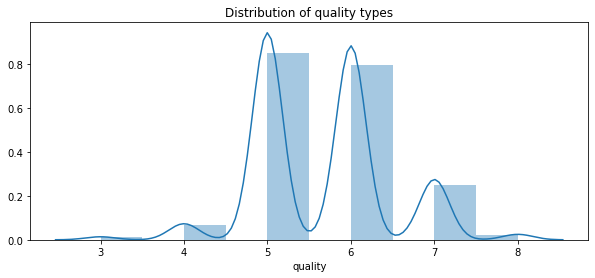

In [8]:
plt.figure(figsize = (10, 4))

sns.distplot(df['quality'], bins=10)

plt.title('Distribution of quality types')
plt.show()

In [9]:
column_names = df.columns.tolist()

Distribution of quality types is close to normal

In [10]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Luckily, data looks clean

In [11]:
df.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

All data is numeric

#### Analysis of outliers

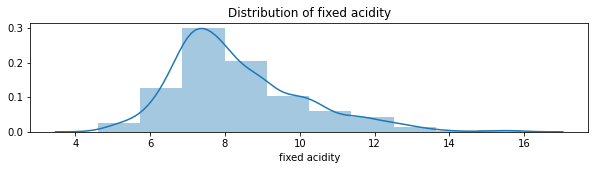

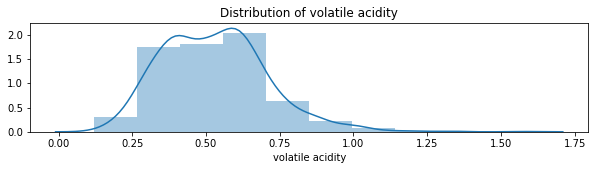

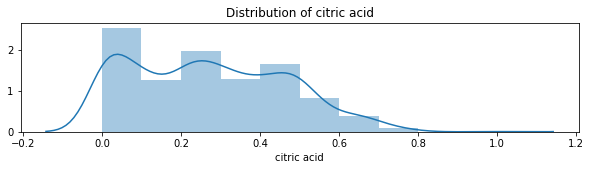

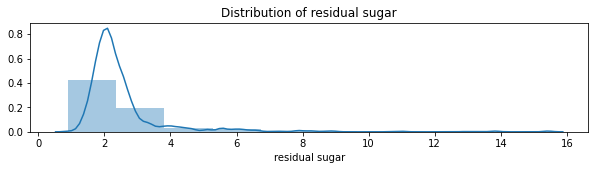

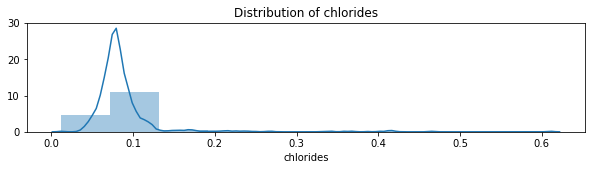

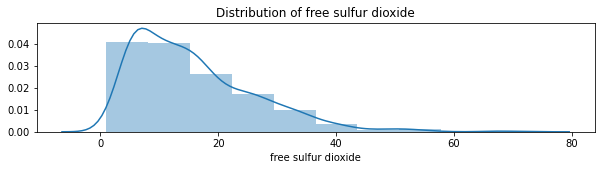

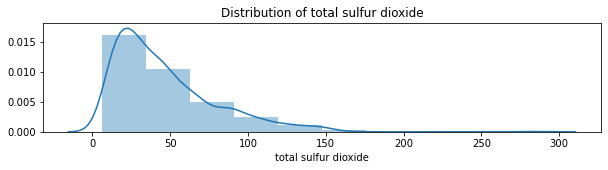

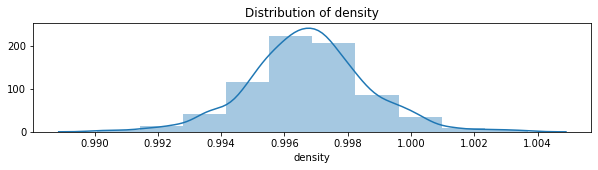

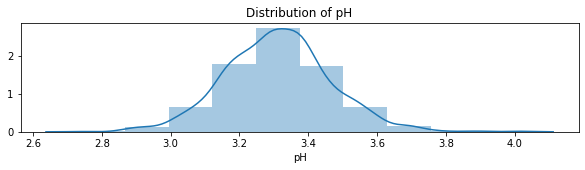

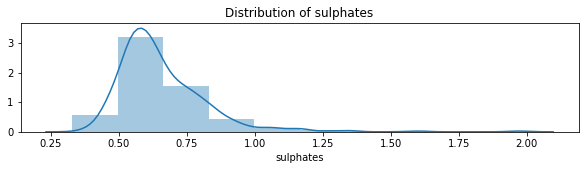

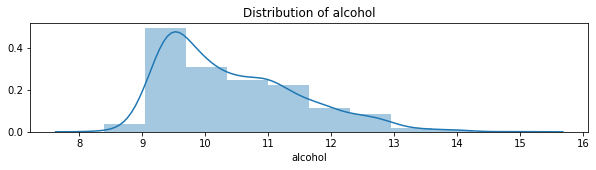

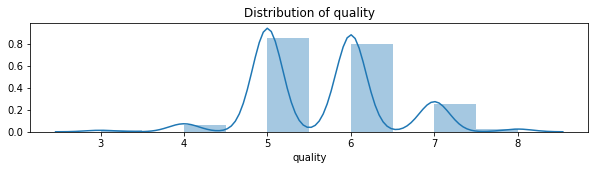

In [12]:
for i in range(len(column_names)):
    
    plt.figure(figsize = (10, 2))

    sns.distplot(df[column_names[i]], bins=10)

    plt.title(f'Distribution of {column_names[i]}')
    plt.show()

Distribution of the features do not show any suspicious behaviour.

In [13]:
df[df['citric acid'] < 0]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality


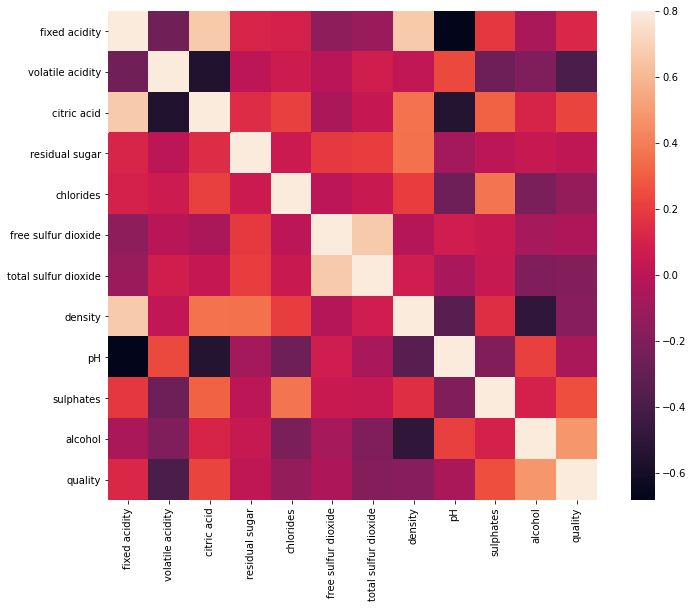

In [14]:
#correlation matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
corrmat.style.background_gradient(cmap='coolwarm')
sns.heatmap(corrmat, vmax=.8, square=True)

Correlation matrix illuctrates negative correlation of quality of wine with volatile acidity and positive correlation with alcohol. The rest of features show less impressive correlation.

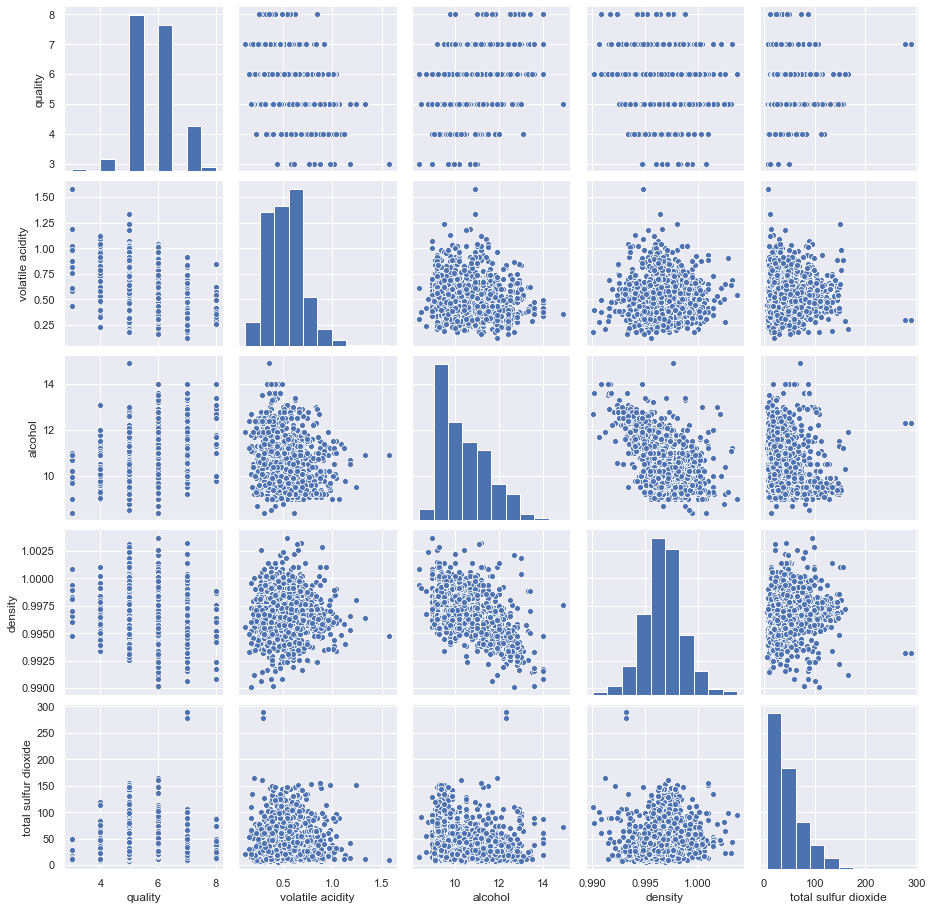

In [15]:
#scatterplot
sns.set()
cols = ['quality', 'volatile acidity', 'alcohol', 'density', 'total sulfur dioxide']
sns.pairplot(df[cols], height = 2.5)
plt.show();

### 3. Data Preparation

In [16]:
predictors = df[['density', 'sulphates', 'alcohol', 'volatile acidity', 'total sulfur dioxide']]
# the most relevant based on the correlation matrix                
                
target = df['quality'] 

In [17]:
# Let's normalize the data by substracting the mean and dividing by the standard deviation
predictors_norm = (predictors - predictors.mean()) / predictors.std()

In [18]:
# Let's divide the dataset into training and test
X_train, X_test, y_train, y_test = train_test_split(predictors_norm, target, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1279, 5), (320, 5), (1279,), (320,))

### 4. Data Modelling

As a metric accuracy will be used

accuracy = (TRUE_POSITIVE + TRUE_NEGATIVE) / (TRUE_POSITIVE + FALSE_POSITIVE + TRUE_NEGATIVE + FALSE_NEGATIVE)

### Baseline - SVC

In [74]:
svc = SVC(C = 1.3, gamma = 1.4, kernel = 'rbf')
svc.fit(X_train, y_train)

SVC(C=1.3, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.4, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [75]:
pred_svc = svc.predict(X_test)
print(classification_report(y_test, pred_svc))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.64      0.75      0.70       130
           6       0.58      0.61      0.59       132
           7       0.55      0.38      0.45        42
           8       0.00      0.00      0.00         5

    accuracy                           0.61       320
   macro avg       0.30      0.29      0.29       320
weighted avg       0.57      0.61      0.59       320



C:\Users\mreun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [76]:
# For obtaining more stable score let's use cross-validation with 10 folds

cv_score = cross_val_score(svc, X_train, y_train, 
                           scoring='accuracy', 
                           cv=KFold(n_splits=10, shuffle=True, random_state=42))
# cv_score
mean_base = cv_score.mean()
print(f'average accuracy of base model - {mean_base}')

average accuracy of base model - 0.6356791338582677


### 4.1 Random Forest Classifier

In [48]:
# Definition of set of parameters for optimizing by GridSearch

parameters = [{'n_estimators': [50, 100, 150], 'max_features': [5], 'max_depth': [7, 8, 10]}]

gs_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=100), param_grid=parameters, scoring='accuracy', cv=5)

gs_rf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=100,
                                 

In [50]:
# Checking best parameters

gs_rf.best_params_

{'max_depth': 10, 'max_features': 5, 'n_estimators': 100}

In [83]:
rfc = RandomForestClassifier(max_depth=10, max_features=5, n_estimators=100)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features=5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [84]:
pred_rfc = rfc.predict(X_test)

In [85]:
print(classification_report(y_test, pred_rfc))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.68      0.80      0.73       130
           6       0.63      0.62      0.63       132
           7       0.60      0.50      0.55        42
           8       0.00      0.00      0.00         5

    accuracy                           0.65       320
   macro avg       0.32      0.32      0.32       320
weighted avg       0.61      0.65      0.63       320



C:\Users\mreun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [86]:
# For obtaining more stable score let's use cross-validation with 10 folds

cv_score = cross_val_score(rfc, X_train, y_train, 
                           scoring='accuracy', 
                           cv=KFold(n_splits=10, shuffle=True, random_state=42))
# cv_score
mean_rf = cv_score.mean()
std_rf = cv_score.std()

In [87]:
print(f'average accuracy of Random Forest - {mean_rf}')

average accuracy of Random Forest - 0.6747416338582677


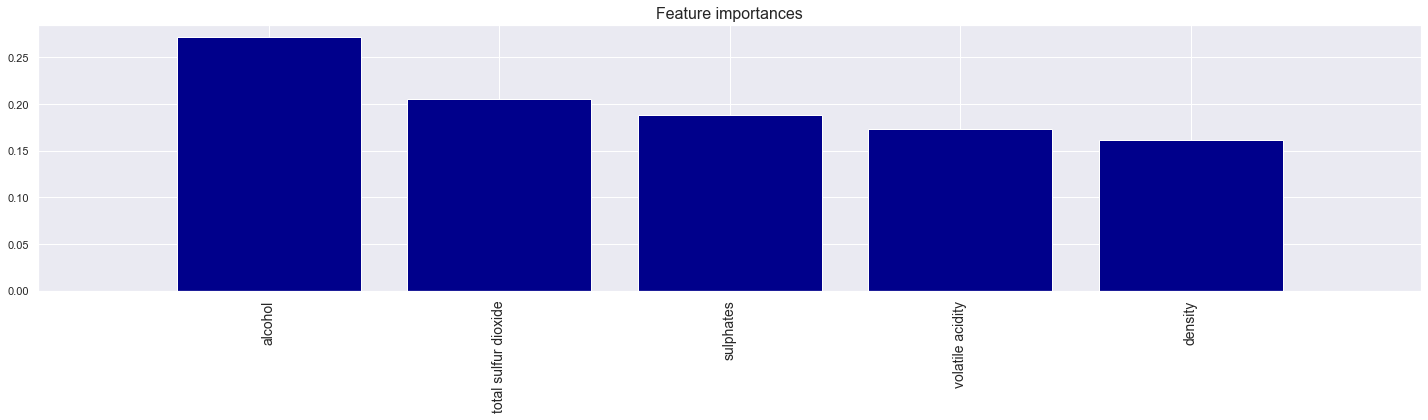

In [59]:
# Plotting the chart with sorted feature importance

def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.show()
    
plot_feature_importances(importances = rfc.feature_importances_, X=predictors)

### 4.2 GradientBoostingClassifier

In [94]:
parameters = [{'n_estimators': [180, 200, 230], 'max_depth': [5,8,10],
               'min_samples_leaf':[10, 15, 20, 25], 'max_features': [4,5]}]

gs_gbc = GridSearchCV(estimator=GradientBoostingClassifier(), param_grid=parameters, scoring='accuracy', cv=5)

gs_gbc.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [95]:
# Checking best parameters

gs_gbc.best_params_

{'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 15,
 'n_estimators': 230}

In [46]:
gbc = GradientBoostingClassifier(max_depth=5, max_features=4, n_estimators=230, min_samples_leaf = 15)
gbc.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=15, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=230,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [47]:
pred_gbc = gbc.predict(X_test)
print(classification_report(y_test, pred_gbc))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.70      0.72      0.71       130
           6       0.61      0.63      0.62       132
           7       0.55      0.57      0.56        42
           8       0.00      0.00      0.00         5

    accuracy                           0.62       320
   macro avg       0.31      0.32      0.31       320
weighted avg       0.61      0.62      0.62       320



C:\Users\mreun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
# For obtaining more stable score let's use cross-validation with 10 folds

cv_score = cross_val_score(gbc, X_train, y_train, 
                           scoring='accuracy', 
                           cv=KFold(n_splits=10, shuffle=True, random_state=42))
# cv_score
mean_gbc = cv_score.mean()
std_gbc = cv_score.std()

In [60]:
print(f'average accuracy of Gradient Boosting - {mean_gbc}')

average accuracy of Gradient Boosting - 0.6520546259842519


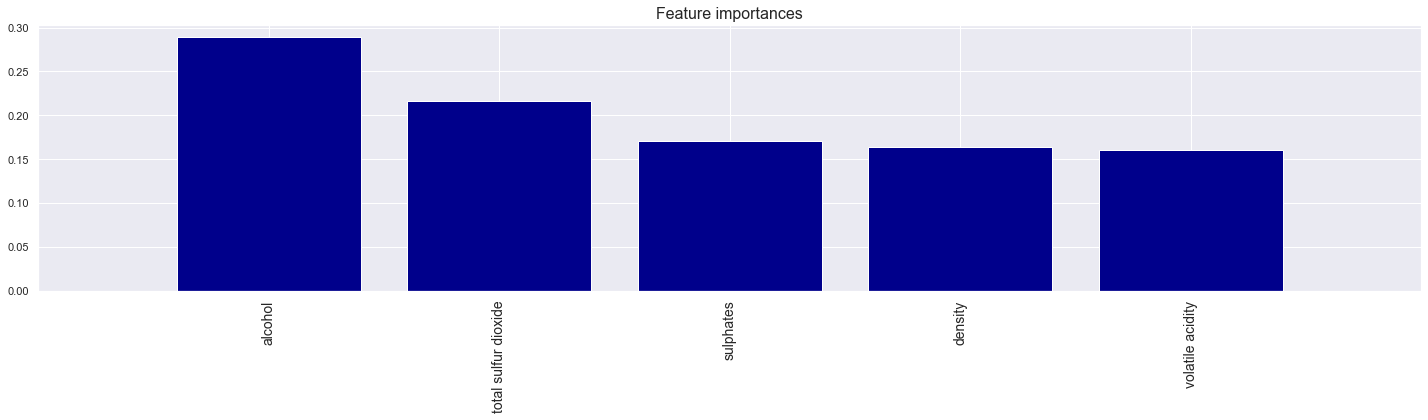

In [39]:
# Plotting the chart with sorted feature importance

def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.show()
    
plot_feature_importances(importances = gbc.feature_importances_, X=predictors)

### 4.3 LGBMClassifier

In [139]:
parameters = [{'n_estimators': [100, 150, 200],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [10, 12, 15],
    'num_leaves': [40, 50, 60],
    'reg_alpha': [1.2, 1.3, 1.4],
    'reg_lambda': [1.2, 1.3, 1.4],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.8, 0.9],
    'subsample_freq': [20]}]

gs_lgbm = GridSearchCV(estimator=LGBMClassifier(), param_grid=parameters, scoring='accuracy', cv=5)

gs_lgbm.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, objective=None,
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=Tru...
             iid='deprecated', n_jobs=None,
             param_grid=[{'colsample_bytree': [0.7, 0.8],
                          'max_depth': [10, 12, 15],
                          'min_split_gain': [0.3, 0.4],
                          'n_estimators': [100, 150, 200],
   

In [134]:
# Checking best parameters

gs_lgbm.best_params_

{'colsample_bytree': 0.7,
 'max_depth': 15,
 'min_split_gain': 0.3,
 'n_estimators': 400,
 'num_leaves': 50,
 'reg_alpha': 1.3,
 'reg_lambda': 1.3,
 'subsample': 0.9,
 'subsample_freq': 20}

In [62]:
lgbm = LGBMClassifier(colsample_bytree = 0.7, max_depth = 10, min_split_gain = 0.3, n_estimators = 80,
                      num_leaves = 30, reg_alpha = 1.3, reg_lambda = 1.3, subsample = 0.9, subsample_freq = 20)
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=80, n_jobs=-1, num_leaves=30, objective=None,
               random_state=None, reg_alpha=1.3, reg_lambda=1.3, silent=True,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=20)

In [63]:
pred_lgbm = lgbm.predict(X_test)
print(classification_report(y_test, pred_lgbm))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        10
           5       0.67      0.72      0.69       130
           6       0.55      0.64      0.59       132
           7       0.50      0.33      0.40        42
           8       0.00      0.00      0.00         5

    accuracy                           0.60       320
   macro avg       0.29      0.28      0.28       320
weighted avg       0.56      0.60      0.58       320



C:\Users\mreun\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
# For obtaining more stable score let's use cross-validation with 10 folds

cv_score = cross_val_score(lgbm, X_train, y_train, 
                           scoring='accuracy', 
                           cv=KFold(n_splits=10, shuffle=True, random_state=42))
# cv_score
mean_lgbm = cv_score.mean()
std_lgbm = cv_score.std()

In [65]:
print(f'average accuracy of LGBM - {mean_lgbm}')

average accuracy of LGBM - 0.629398375984252


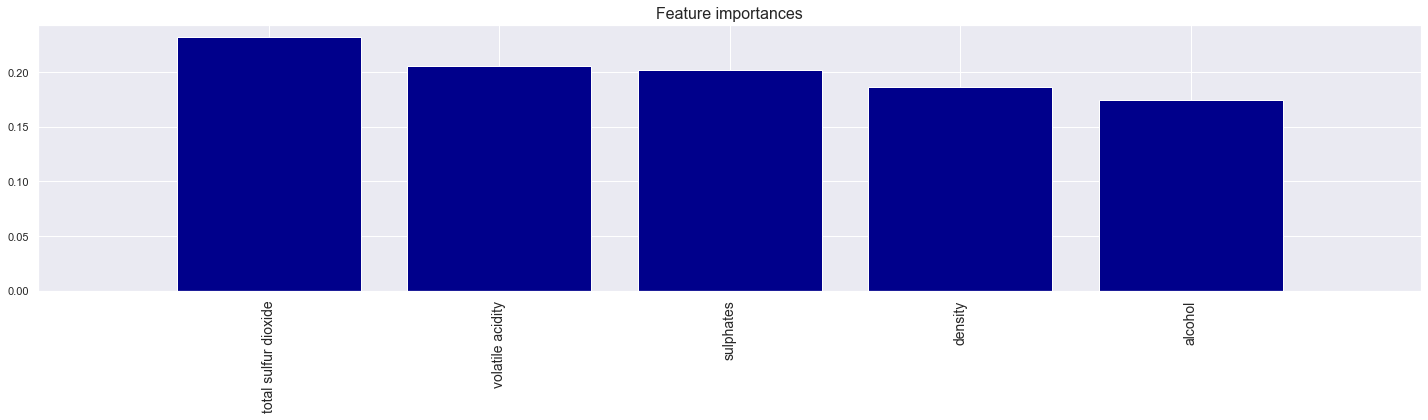

In [66]:
# Plotting the chart with sorted feature importance

def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    plt.show()
    
plot_feature_importances(importances = lgbm.feature_importances_, X=predictors)

#### Conclusion

In [88]:
score_base = ["SVC_base", mean_base]
score_rf = ["RandomForest", mean_rf]
score_gbc = ["GradientBoosting", mean_gbc]
score_lgbm = ["LightGBM", mean_lgbm]

In [90]:
df = pd.DataFrame([score_base,score_rf,score_gbc,score_lgbm], columns = ["Method","Score"])

In [91]:
df

,Method,Score
0,SVC_base,0.635679
1,RandomForest,0.674742
2,GradientBoosting,0.652055
3,LightGBM,0.629398


As a baseline method of Support Vector Machine was choosen, and it demonstrated accuracy of 63.5%. Methods of random forest and gradient boosting shown better results - 67.5% and 65% respectively. Light GBM resulted in accuracy lower that the base model.